# Preliminary Analysis
The main goal is to predict whether the patient got a stroke based on the attributes such as age,heart disease,smoking status,etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
sns.set(style="ticks")
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder 
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [2]:
data=pd.read_csv("C:/Users/Sneha/Desktop/DATA/Stroke.csv")

Let's take a peek at the top few row of the dataset

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


Let's get more information to see how much data is missing

In [5]:
data.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [6]:
data.isnull().sum()/len(data)*100

id                    0.000000
gender                0.000000
age                   0.000000
hypertension          0.000000
heart_disease         0.000000
ever_married          0.000000
work_type             0.000000
Residence_type        0.000000
avg_glucose_level     0.000000
bmi                   3.368664
smoking_status       30.626728
stroke                0.000000
dtype: float64

In [7]:
data.smoking_status.unique()

array([nan, 'never smoked', 'formerly smoked', 'smokes'], dtype=object)

In [8]:
# Filling missing values with 'Unknown'
data['smoking_status'].fillna('Unknown',inplace=True)

In [9]:
#Splitting the dataset into Features & Target
data_feat=data.drop('stroke',axis=1)
data_labels=data['stroke']
print(data_feat.shape)
print(data_labels.shape)

(43400, 11)
(43400,)


# Data preparation pipeline

Build the data preparation pipeline

. DataFrameSelector: select specific attributes from data frame

. Imputer for numerical variables(by replacing the missing value with the 'median' value of the particular col.)

. Scalar(Scaled the num col. using StandardScaler)

. Encoding Categorical columns using OneHotEncoder

In [10]:
# Data Frame Selector

from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

In [11]:
from sklearn.pipeline import FeatureUnion

cat_attributes=['gender','ever_married','work_type','Residence_type','smoking_status']
num_attributes=['age','avg_glucose_level','bmi']

num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attributes)),
    ('imputer',SimpleImputer(strategy='median')),
    ('std_scaler',StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attributes)),
    ('1_hot_enc',OneHotEncoder()),
])

# Combine the two pipelines
full_pipeline= FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),
])

data_prepared = full_pipeline.fit_transform(data_feat).toarray()
data_prepared=pd.DataFrame(data_prepared)

In [12]:
data_prepared.isnull().sum()/len(data)*100

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
dtype: float64

In [13]:
data_prepared.shape

(43400, 19)

 Check whether the data is balanced/imbalanced

In [15]:
Stroke_1 = data[data['stroke']==1]

Stroke_0 = data[data['stroke']==0]

In [16]:
print(Stroke_1.shape,Stroke_0.shape)

(783, 12) (42617, 12)


Converting the imbalanced data into balanced data using imblearn's "SMOTETomek".

In [17]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=42)

feat_res,labels_res = smk.fit_sample(data_prepared,data_labels)

Using TensorFlow backend.


In [18]:
feat_res.shape,labels_res.shape

((84588, 19), (84588,))

In [19]:
from collections import Counter
print('Original Dataset Shape {}'.format(Counter(data_labels)))

print('Resampled Dataset Shape {}'.format(Counter(labels_res)))

Original Dataset Shape Counter({0: 42617, 1: 783})
Resampled Dataset Shape Counter({0: 42294, 1: 42294})


# Select and train a model

I compared 9 popular classifiers and evaluate the mean accuracy of each of them using a stratified kfold cross validation procedure.

. Logistic regression

. Linear Discriminant Analysis

. KNN

. SVM

. Decision Tree

. Random Forest

. AdaBoost

. Gradient Boosting 

. Neural Network (Multiple layer perceptron)

In [20]:
#Common Model Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

#Common Model Helpers
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score, StratifiedKFold, learning_curve, cross_validate

In [21]:
#Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

In [22]:
#Initialize different algorithms with default parameters
random_state = 2
classifiers = [
              LogisticRegression(random_state = random_state),
              LinearDiscriminantAnalysis(),
              KNeighborsClassifier(),
              SVC(random_state=random_state),
              DecisionTreeClassifier(random_state=random_state),
              RandomForestClassifier(random_state=random_state),
              AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1),
              GradientBoostingClassifier(random_state=random_state),
              MLPClassifier(random_state=random_state)
              ]

# save the cross-validation results
#create table to compare MLA metrics
res_columns = ['CLF Name', 'CLF Parameters','CLF Test Accuracy Mean', 'CLF Test Accuracy STD']
res_compare = pd.DataFrame(columns = res_columns)

row_index = 0
for CLF in classifiers:
    CLF_name = CLF.__class__.__name__
    res_compare.loc[row_index, 'CLF Name'] = CLF_name
    res_compare.loc[row_index, 'CLF Parameters'] = str(CLF.get_params())
    cv_result = cross_val_score(CLF, feat_res,labels_res, scoring = "accuracy", cv = kfold, n_jobs=2)
    
    res_compare.loc[row_index, 'CLF Test Accuracy Mean'] = cv_result.mean() 
    res_compare.loc[row_index, 'CLF Test Accuracy STD'] = cv_result.std()
    
    row_index+=1
    
res_compare.sort_values(by = ['CLF Test Accuracy Mean'], ascending = False, inplace = True)
res_compare

,CLF Name,CLF Parameters,CLF Test Accuracy Mean,CLF Test Accuracy STD
4,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.971013,0.0107439
6,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__ccp_...",0.970953,0.0104531
5,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.969086,0.00446866
2,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.935795,0.00244537
8,MLPClassifier,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",0.903213,0.00322706
7,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.861635,0.0042118
3,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.859862,0.00371043
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.793919,0.00150833
1,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.793446,0.00155527


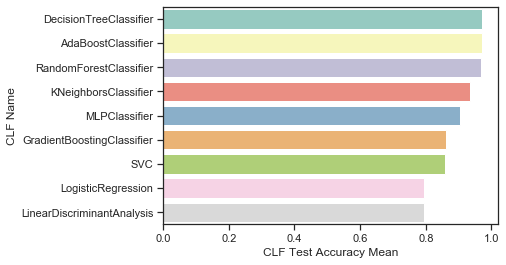

In [23]:
sns.barplot(x='CLF Test Accuracy Mean', y='CLF Name', data= res_compare, palette= 'Set3')

# Fine-tune the selected models

Let's perform a random search optimization for AdaBoost,RandomForest,GradientBoosting and SVC classifiers.

In [24]:
# Adaboost

DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=2)

ada_param = [{
    "base_estimator__criterion" : ["gini", "entropy"],
    "base_estimator__splitter" :   ["best", "random"],
    "n_estimators" :[30,100,300],
    "learning_rate":  [0.01, 0.03, 0.1, 0.3]
}]

rs_adaDTC = RandomizedSearchCV(adaDTC,param_distributions = ada_param, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

rs_adaDTC.fit(feat_res,labels_res)
rs_adaDTC.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.1s finished


{'n_estimators': 30,
 'learning_rate': 0.1,
 'base_estimator__splitter': 'best',
 'base_estimator__criterion': 'entropy'}

In [25]:
# Random Forest

RFC = RandomForestClassifier()

rf_param = [
    {"bootstrap": [True,False],
     'n_estimators':[100,300,500],
     'max_features' :['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
    'max_depth': [10,20,30,40,50],
    'criterion': ['gini','entropy']}
]

rs_RFC = RandomizedSearchCV(RFC,param_distributions = rf_param, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

rs_RFC.fit(feat_res,labels_res)
rs_RFC.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.2min finished


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'criterion': 'gini',
 'bootstrap': False}

In [26]:
# Gradient boosting

GBC = GradientBoostingClassifier()
gb_param = [{
              'n_estimators' : [30,100,300],
              'learning_rate': [0.01, 0.03, 0.1],
              'max_depth': [10,20,30,40,50],
              'min_samples_split': [2, 5, 10],
              'max_features' :['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4, 6]
              }]

rs_GBC = RandomizedSearchCV(GBC,param_distributions = gb_param, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

rs_GBC.fit(feat_res,labels_res)
rs_GBC.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 27.0min finished


{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 6,
 'max_features': 'auto',
 'max_depth': 20,
 'learning_rate': 0.03}

# Plot  the learning curve

Let's plot the learning curve to see accuracy score against training size.It's a good way to see the overfitting effect.

In [27]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """generate training and testing dataset training curve."""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("the size of Training set")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
   
    plt.grid()
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    
    
    plt.legend(loc="best")
    return

In [28]:
RFC_best = rs_RFC.best_estimator_

ada_best = rs_adaDTC.best_estimator_

GBC_best = rs_GBC.best_estimator_

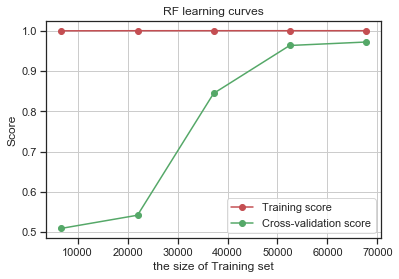

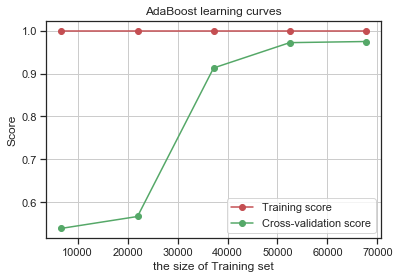

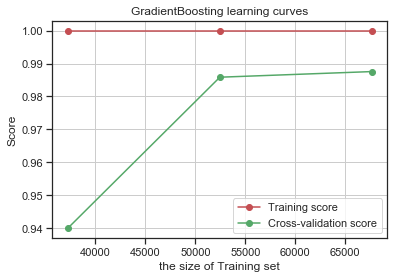

In [29]:
g = plot_learning_curve(RFC_best,"RF learning curves",feat_res,labels_res,cv=kfold)

g = plot_learning_curve(ada_best,"AdaBoost learning curves",feat_res,labels_res,cv=kfold)

g = plot_learning_curve(GBC_best,"GradientBoosting learning curves",feat_res,labels_res,cv=kfold)

Higher the score(y-axis), better the model's performance.

1 . Training score (red line) of all the models is at its's maximum regardless of training examples. This shows severe overfitting in all the models.
    
2 . Cross validation score (green line) increases over time.

3 . Huge gap between cross-validation score & training score (GradientBoosting) indicates high variance scenario. Reduce complexity of the model or gather more data.
    
4 . Random Forest & AdaBoost classifier seems generalize better prediction since the training & testing cross-validation learning curve are close to each other.

# Ensemble or Stack the models

Let's use a voting classifier to combine the predictions coming from the 5 classifiers.

In [43]:
labels = ['Random Forest', 'Ada Boost', 'Gradient Boost', 'Voting Classifier']

votingC = VotingClassifier(estimators=[('rfc',RFC_best),('adac',ada_best),('gbc',GBC_best)], voting='hard', n_jobs=-1)

votingC = votingC.fit(feat_res,labels_res)

In [44]:
for clf, label in zip([RFC_best, ada_best, GBC_best, votingC], labels):
    
    scores = cross_val_score(clf,feat_res,labels_res, cv=kfold, scoring = 'accuracy')
    print('(Accuracy: %0.5f) (STD: % 0.5f) [%s]' % (scores.mean(), scores.std(), label))

(Accuracy: 0.97191) (STD:  0.00545) [Random Forest]
(Accuracy: 0.97506) (STD:  0.01150) [Ada Boost]
(Accuracy: 0.98776) (STD:  0.01408) [Gradient Boost]
(Accuracy: 0.98675) (STD:  0.01324) [Voting Classifier]
